# Image classification using CNN

**Esther SunYoung CHOI**

Image classification is a fundamental task in Computer Vision that consists of assigning a specific label to an image.

The goal of this project is to implement a Convolutional Neural Network (CNN) to perform image classification using PyTorch.


## Table of Contents
1. [Intro to CNN](#intro)
1. [Importing modules](#modules)
1. [Exploring the data](#explore)
1. [Building a model](#build)
1. [Training the model](#train)
1. [Improving our first model](#improve)
1. [Visualizing results](#results)
1. [Conclusion](#ccl)

<a name="intro"></a>
## Intro to CNN

Convolutional Neural Networks have become the state-of-the-art architecture in almost all Machine Learning tasks applied to images. They differ from traditional neural networks by the types of layers they use : convolutional layers and pooling layers.

### Convolutional layers

Convolutional layers perform a convolution operation between the input data and a feature detector, called kernel or filter. The filter is a small matrix that we pass over each pixel of the input image and allows the detection of features such as straight lines, edges or circles.

It is usually followed by an activation layer.

### Pooling layers

Pooling layers aggregate the values of the ouput tensor of convolutional layers to reduce its dimensions and amplify the extracted feature.

Common pooling functions include max pooling and average pooling that takes respectively the maximum and average value of a small aggregate of pixels.

### Fully connected layers

Fully connected layers are nothing more than a classic neural network where all neurons are connected to all neurons of the next layer, hence the name.

**CNNs thus consist of two main parts : a convolutional/pooling part that breaks down the image into features and a fully connected neural network to take the final decision.**

<a name="modules"></a>
## Importing all useful modules

In [1]:
import time
import random

from google.colab import output

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

<a name="explore"></a>
## Exploring the data

We will be using the [CIFAR-10 database](https://www.cs.toronto.edu/~kriz/cifar.html) that contains 10 classes of 32x32 RGB images, 50k in train and 10k in test.

In [2]:
def get_dataset(batch_size, cuda=False):
    """
    Loads the CIFAR-10 dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    trainset = datasets.CIFAR10(root='./data', train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    testset = datasets.CIFAR10(root='./data', train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(trainset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(testset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader

In [3]:
BATCH_SIZE = 128
PRINT_INTERVAL = 200
CUDA = True    # True if available GPU, False otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Let's display a few images.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


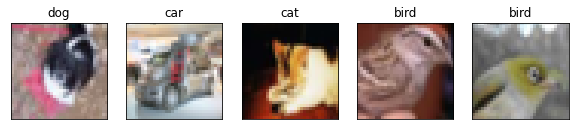

In [4]:
train, test = get_dataset(batch_size=BATCH_SIZE,cuda=CUDA)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_features, train_labels = next(iter(train))    

plt.figure(figsize=(10, 4))
for i in range(5):
    ax = plt.subplot(1,5,i+1)
    num = random.randint(0, train_features.shape[0])
    img = train_features[num].numpy().transpose((1,2,0))
    plt.imshow(img)
    plt.title("{}".format(classes[train_labels[num]]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

<a name="build"></a>
## Building a model

In this paragraph, we will note $D$ the number of channels, $k$ the width of the filter (and its height as we will use square filters), $p$ the padding and $s$ the stride.

The first model we are going to build will be composed of the following layers :
- `conv1` : convolution layer with $D=32, k=5, p=2, s=1$ and ReLU activation
- `pool1` : max-pooling with window of size 2x2, $p=0, s=2$
- `conv2` : convolution layer with $D=64, k=5, p=2, s=1$ and ReLU activation
- `pool2` : max-pooling with window of size 2x2, $p=0, s=2$
- `conv3` : convolution layer with $D=64, k=5, p=2, s=1$ and ReLU activation
- `pool3` : max-pooling with window of size 2x2, $p=0, s=2$
- `fc4` : fully-connected layer with 1000 output neurons, with ReLU activation
- `fc5` : fully-connected layer with 10 output neurons, with softmax activation

The values of padding and stride are chosen so that the output of convolution layers have the same spatial dimensions as the input, and so that pooling layers divide spatial dimensions by 2.

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()

        # Defining the convolution and pooling layers as a feature extractors
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),              # conv1
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),                  # pool1
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),             # conv2
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),                  # pool2
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),             # conv3
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode = True) # pool3
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),  # fc4
            nn.ReLU(),
            nn.Linear(1000, 10)     # fc5
            ## The softmax output is included in the cross entropy loss function
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the convolution layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

In [ ]:
model = ConvNet()
summary(model.to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          51,264
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]         102,464
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                 [-1, 1000]       1,025,000
             ReLU-11                 [-1, 1000]               0
           Linear-12                   [-1, 10]          10,010
Total params: 1,191,170
Trainable params: 1,191,170
Non-trainable params: 0
---------------------------

There are 1,191,170 parameters in total. Considering that there are only 50k training samples, there is a high risk of overfitting.

<a name="train"></a>
## Training the model

Next step is to train the model we have just built.

To do so, we will use the cross-entropy as loss function, with the Adam optimizer.

The following cell contains an accuracy function to compute the precision@k metric and classes to plot accuracy and losses.

In [5]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, keep_all=False):
        self.reset()
        self.data = None
        if keep_all:
            self.data = []

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if self.data is not None:
            self.data.append(val)
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

class TrainLossPlot(object):
    def __init__(self):
        self.loss_train = []
        self.fig = plt.figure()

    def update(self, loss_train):
        self.loss_train.append(loss_train)

class AccLossPlot(object):
    def __init__(self):
        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []
        self.fig = plt.figure()

    def update(self, loss_train, loss_test, acc_train, acc_test):
        self.loss_train.append(loss_train)
        self.loss_test.append(loss_test)
        self.acc_train.append(acc_train)
        self.acc_test.append(acc_test)
        plt.figure(self.fig.number)
        plt.clf()
        plt.subplot(1,2,1)
        plt.plot(np.array(self.acc_train), label="acc. train")
        plt.plot(np.array(self.acc_test), label="acc. test")
        plt.title("Accuracy / epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(np.array(self.loss_train), label="loss train")
        plt.plot(np.array(self.loss_test), label="loss test")
        plt.title("Loss / epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        plt.draw_all()
        plt.pause(1e-3)

The following cell contains the code to perform a training epoch. At the end of each batch training, we print the loss and the accuracy and their average in brackets.

In [6]:
def epoch(data, model, criterion,optimizer=None, cuda=False):
    """
    Make an epoch on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)

        if True: 
          if i % PRINT_INTERVAL == 0:
              print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                    'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                    'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                    'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                    "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                    top1=avg_top1_acc, top5=avg_top5_acc))

    # Print summary
    if True: 
      print('\n===============> Total time {batch_time:d}s\t'
            'Avg loss {loss.avg:.4f}\t'
            'Avg Prec@1 {top1.avg:5.2f} %\t'
            'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
            batch_time=int(avg_batch_time.sum), loss=avg_loss,
            top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


The `main` function loads the CIFAR-10 dataset, and runs the training process with the settings given by the arguments (batch size, number of epochs, learning rate if needed by the optimizer and the presence of GPUs). We will use the Adam optimizer for a faster training.

In [7]:
def main(model, batch_size=128, lr=None, epochs=100, cuda=False):   
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(model.parameters(), lr)
    optimizer = torch.optim.Adam(model.parameters())

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        output.clear()

        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")

        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot        
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

Let's train our first model.

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.142s (0.142s)	Loss 0.0407 (0.0407)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)
[TRAIN Batch 200/391]	Time 0.007s (0.019s)	Loss 0.0476 (0.0614)	Prec@1  97.7 ( 97.9)	Prec@5 100.0 (100.0)

===============> Total time 7s	Avg loss 0.0637	Avg Prec@1 97.87 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.134s (0.134s)	Loss 1.6794 (1.6794)	Prec@1  69.5 ( 69.5)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.7357	Avg Prec@1 72.30 %	Avg Prec@5 97.27 %



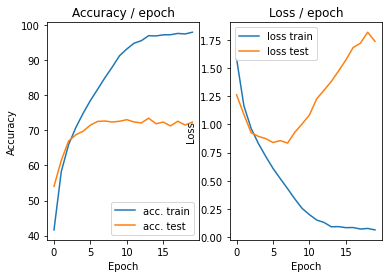

In [ ]:
model = ConvNet()
main(model,batch_size=128, epochs=20, cuda=CUDA)

The test accuracy is around 70%, which seems not bad for a first model, but the train accuracy is nearly 98% and the test loss increasing after 5 to 8 epochs : there is clearly an overfitting issue, as we had expected.

There exists several ways to handle overfitting including reducing the number of trainable parameters, adding Dropout layers and reducing the batch size.

<a name="improve"></a>
## Improving our first model

Dropout layers randomly remove certain features by setting them to 0 at each epoch. The model tries different combinations of neurons during and training and thus encourage the model to use all neurons individually (as their neighbors may be desactivated at any time).

Below, we define another architecture using all these solutions.

In [ ]:
class ConvNetReducedDropout(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNetReducedDropout, self).__init__()

        # Defining the convolution and pooling layers as a feature extractors
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(16, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode = True)
        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(4*4*32, 256),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(256, 10)
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the convolution layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

In [ ]:
model2 = ConvNetReducedDropout()
summary(model2.to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]           1,216
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]          12,832
              ReLU-5           [-1, 32, 16, 16]               0
           Dropout-6           [-1, 32, 16, 16]               0
         MaxPool2d-7             [-1, 32, 8, 8]               0
            Conv2d-8             [-1, 32, 8, 8]          25,632
              ReLU-9             [-1, 32, 8, 8]               0
        MaxPool2d-10             [-1, 32, 4, 4]               0
           Linear-11                  [-1, 256]         131,328
             ReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                   

This model has about 10 times less parameters than our first model.

=== EPOCH 20 =====

[TRAIN Batch 000/782]	Time 0.131s (0.131s)	Loss 0.6421 (0.6421)	Prec@1  70.3 ( 70.3)	Prec@5  96.9 ( 96.9)
[TRAIN Batch 200/782]	Time 0.012s (0.013s)	Loss 0.5034 (0.6443)	Prec@1  84.4 ( 76.9)	Prec@5 100.0 ( 98.8)
[TRAIN Batch 400/782]	Time 0.010s (0.013s)	Loss 0.6882 (0.6567)	Prec@1  73.4 ( 76.6)	Prec@5 100.0 ( 98.8)
[TRAIN Batch 600/782]	Time 0.006s (0.013s)	Loss 0.7397 (0.6623)	Prec@1  76.6 ( 76.4)	Prec@5 100.0 ( 98.7)

===============> Total time 9s	Avg loss 0.6726	Avg Prec@1 76.07 %	Avg Prec@5 98.68 %

[EVAL Batch 000/157]	Time 0.122s (0.122s)	Loss 0.7481 (0.7481)	Prec@1  73.4 ( 73.4)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 0.8179	Avg Prec@1 71.40 %	Avg Prec@5 97.68 %



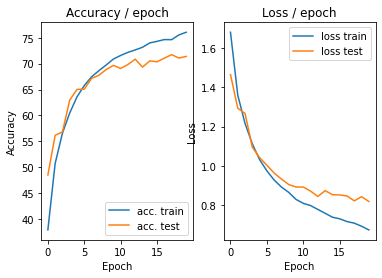

In [ ]:
main(model2, batch_size=64, epochs=20, cuda=CUDA)

Both train and test loss continue decreasing, and the train accuracy isn't as high as before : we have avoided overfitting. However, test accuracy didn't improve significantly and probably won't even if we train our model longer.

On Kaggle we can find better models that reach more than 80% of accuracy. It is the case of [this Kaggle notebook](https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy/notebook), reimplemented below.

In [8]:
class ConvNet2(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet2, self).__init__()

        # Defining the convolution and pooling layers as a feature extractors
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Dropout(0.5),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128), 
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Dropout(0.5)
        )

        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(4*4*128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the convolution layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

In [9]:
modeltuto = ConvNet2()
summary(modeltuto.to(device),(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
           Dropout-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]          36,928
             ReLU-13           [-1, 64, 16, 16]               0
      BatchNorm2d-14           [-1, 64,

This model has more parameters than our second model but still less than the first one.

=== EPOCH 20 =====

[TRAIN Batch 000/1563]	Time 0.126s (0.126s)	Loss 0.5142 (0.5142)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)
[TRAIN Batch 200/1563]	Time 0.013s (0.013s)	Loss 0.6283 (0.4710)	Prec@1  87.5 ( 83.7)	Prec@5  96.9 ( 99.4)
[TRAIN Batch 400/1563]	Time 0.014s (0.013s)	Loss 0.4196 (0.4725)	Prec@1  87.5 ( 83.7)	Prec@5 100.0 ( 99.4)
[TRAIN Batch 600/1563]	Time 0.013s (0.013s)	Loss 0.5666 (0.4704)	Prec@1  75.0 ( 83.7)	Prec@5 100.0 ( 99.3)
[TRAIN Batch 800/1563]	Time 0.013s (0.013s)	Loss 0.7013 (0.4789)	Prec@1  75.0 ( 83.4)	Prec@5 100.0 ( 99.3)
[TRAIN Batch 1000/1563]	Time 0.012s (0.013s)	Loss 0.4375 (0.4808)	Prec@1  84.4 ( 83.4)	Prec@5 100.0 ( 99.3)
[TRAIN Batch 1200/1563]	Time 0.012s (0.013s)	Loss 0.5504 (0.4793)	Prec@1  78.1 ( 83.5)	Prec@5 100.0 ( 99.3)
[TRAIN Batch 1400/1563]	Time 0.013s (0.013s)	Loss 0.4179 (0.4822)	Prec@1  78.1 ( 83.4)	Prec@5 100.0 ( 99.3)

===============> Total time 20s	Avg loss 0.4817	Avg Prec@1 83.49 %	Avg Prec@5 99.26 %

[EVAL Batch 000/313]	Time 0.105s 

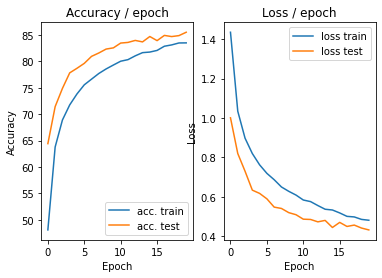

In [10]:
main(modeltuto, batch_size=32, epochs=20, cuda=CUDA)

We now have 85% of test accuracy, and we could even continue training until we really reach convergence on the loss curves.

This can be explained by the use of both batch normalization and dropout and low batch size for training, but also by the hyperparameters used for the different layers.

The first layers in a CNNs usually detect low level features like edges. They don't need a lot of channels. The last layers extract more subtle features like wings, wheels, etc.

This means that the deeper we go in the network, the more channels there should be in order to catch more nuanced details, which is accentuated in this architecture.

<a name="results"></a>
## Visualizing results

### With the second model

In [11]:
# Loading full test dataset
train, test = get_dataset(batch_size=5000,cuda=CUDA)
iter_test = iter(test)
test_features,test_labels = iter_test.next()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Predicted classes using the second model
model2cpu = model2.cpu()
y_pred = model2cpu.forward(test_features)
y_pred_classes = [np.argmax(element) for element in y_pred.detach().numpy()]

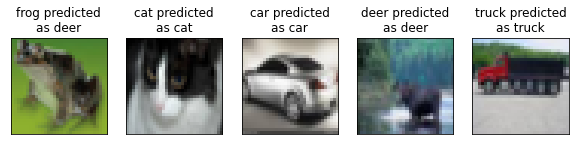

In [ ]:
plt.figure(figsize=(10, 4))
for i in range(5):
    ax = plt.subplot(1,5,i+1)
    num = random.randint(0, test_features.shape[0])
    img = test_features[num].numpy().transpose((1,2,0))
    plt.imshow(img)
    plt.title("{} predicted\nas {}".format(classes[test_labels[num]],classes[y_pred_classes[num]]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

We may want to know which categories were better predicted compared to others. The `classification_report` function from scikit-learn allows us to see that through the following three classification metrics :

* precision = proportion of predicted positives that is truly positive : $\frac{tp}{tp+fp}$
* recall = proportion of actual positives that are correctly classified : $\frac{tp}{tp+fn}$
* F1-score = harmonic mean of precision and recall : $2\times\frac{precision \times recall}{precesion+recall}$

where tp stands for true positive, fp for false positive, tn for true negative and fn for false negative.

In [ ]:
print("model classification report: \n\n", classification_report(test_labels, y_pred_classes))

model classification report: 

               precision    recall  f1-score   support

           0       0.73      0.78      0.75      1000
           1       0.84      0.83      0.83      1000
           2       0.67      0.56      0.61      1000
           3       0.50      0.60      0.55      1000
           4       0.65      0.66      0.66      1000
           5       0.74      0.48      0.59      1000
           6       0.67      0.85      0.75      1000
           7       0.74      0.80      0.77      1000
           8       0.85      0.81      0.83      1000
           9       0.83      0.76      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



We can also show the confusion matrix for a more visual interpretation of results.

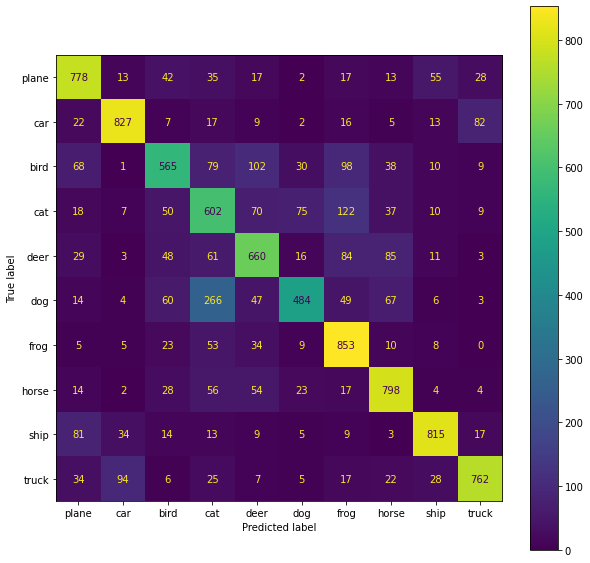

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
cm = confusion_matrix(test_labels, y_pred_classes)
cm_display = ConfusionMatrixDisplay(cm,display_labels=classes).plot(ax=ax)

### With the tutorial model

In [12]:
# Predicted classes using the second model
modeltutocpu = modeltuto.cpu()
y_pred = modeltutocpu.forward(test_features)
y_pred_classes = [np.argmax(element) for element in y_pred.detach().numpy()]

print("modeltuto classification report: \n\n", classification_report(test_labels, y_pred_classes))

modeltuto classification report: 

               precision    recall  f1-score   support

           0       0.81      0.89      0.85       488
           1       0.93      0.93      0.93       505
           2       0.86      0.72      0.78       512
           3       0.76      0.71      0.74       497
           4       0.82      0.86      0.84       507
           5       0.82      0.76      0.79       488
           6       0.86      0.90      0.88       491
           7       0.86      0.91      0.88       495
           8       0.90      0.93      0.91       504
           9       0.90      0.92      0.91       513

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



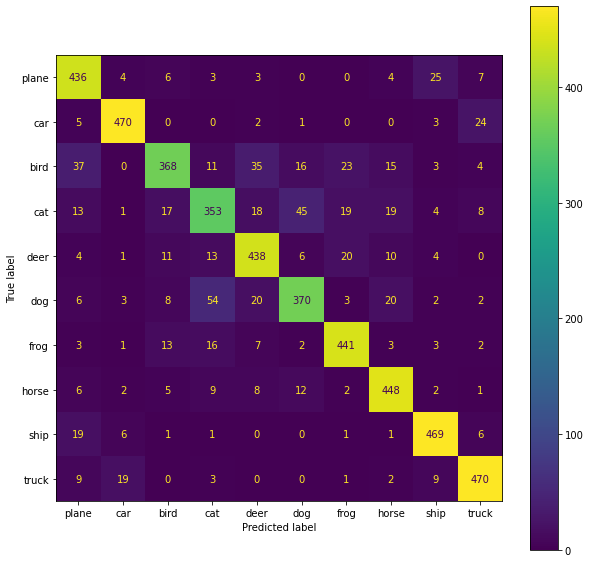

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
cm = confusion_matrix(test_labels, y_pred_classes)
cm_display = ConfusionMatrixDisplay(cm,display_labels=classes).plot(ax=ax)

<a name="ccl"></a>
## Conclusion

We have first built a model that showed strong overfitting. We then modified it to reduce overfitting, which gave a little better results proving that our solutions helped indeed fighting the problem.

We finally reimplemented a model from Kaggle and discussed about why it performed much better.

Future works could be doing data augmentation to generate more training samples and make our models invariant to rotation, illumination, translation, etc, or using pre-trained models and use transfer learning to classify images of this dataset.